In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy

import scipy.stats as stats
import pylab as pl

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# loanamount = float(input("Enter your loan amount? "))
loanamount = 30000
loan_period_years=5
assumed_loan_duration_years=5

In [3]:
data1=pd.read_csv('personal_loans_history_19_03_2018.csv',sep=',')

In [4]:

data1.columns

Index(['Average of Min and Max', 'Firstdayeachmonth', 'Company + Product',
       'Company + Variation', 'Secured PL', 'productcount', 'Extrarepaypoints',
       'dailyrepaypoints', 'weeklyrepaypoints', 'Monthlyrepaypoints',
       ...
       'Productid', 'Redrawactivationfee', 'Repaymentfreq', 'Repaymenttype',
       'Securedbyothers', 'Securedtype', 'Specialconditions',
       'uuid (custom sql query1)', 'Uuid', 'variationid'],
      dtype='object', length=111)

# Cost Score Calculation

In [5]:
data1['Maxrate']=data1['Maxrate'].replace([np.NaN,np.nan,'Null',None],0)
data1['Minrate']=data1['Minrate'].replace([np.NaN,np.nan,'Null',None],0)
data1['Average Rate'] = (data1['Maxrate']+ data1['Minrate'])/2

In [6]:
data1['introrate']=data1['introrate'].replace([np.NaN,np.nan,'Null',None],0)

In [7]:
def intial_repayment(row):
    if (row['introrate'] == 0): ## or (row['introrate'] == '')
        return (loanamount/((1-(1+(row['average_rate']/1200))**(-12*assumed_loan_duration_years))/((row['average_rate']/1200))))
    else:
        return (loanamount/((1-(1+(row['introrate']/1200))**(-12*assumed_loan_duration_years))/((row['introrate']/1200))))

data1['Intial_Repayment']=data1.apply(intial_repayment, axis=1)       

In [8]:
def bal_outst(row):
    if (row['introrate'] > 0):
        return (row['Initial_Repayment']*((1-(1+(row['introrate']/1200))**(-(12*assumed_loan_duration_years-row['introterm'])))/((row['introrate']/1200))))
    else:
        return 0        
            
data1['balance_outstanding']=  data1.apply(bal_outst , axis=1)      

In [10]:
data1['Repayment']= data1['Intial_Repayment'] * loan_period_years*12

In [11]:
data1['Ongoingfeesfrequency'].unique()

array(['Monthly', 'Annually', 'Semi-annually', 'Weekly', 'Quarterly'], dtype=object)

In [12]:
data1['applicationfeesdollar (custom sql query1)'].unique()

array([  nan,  250.,  120.,  200.,  150.,  195.,    0.,  499.])

In [13]:
data1['Applicationfeespercent'].unique()

array([0])

In [14]:
data1['applicationfeespercent (custom sql query1)'].unique()

array([ nan])

In [15]:
data1['applicationfeespercent (custom sql query1)']=data1['applicationfeespercent (custom sql query1)'].replace(np.nan,-1)
data1['applicationfeesdollar (custom sql query1)']=data1['applicationfeesdollar (custom sql query1)'].replace(np.nan,-1)
data1['Applicationfeespercent']=data1['Applicationfeespercent'].replace(0,-1)

In [16]:
data1['Applicationfeespercent'].unique()

array([-1])

In [17]:
def fees(row):
    if (row['applicationfeespercent (custom sql query1)']== -1)and (row['applicationfeesdollar (custom sql query1)']== -1):
        if (row['Ongoingfeesfrequency'] == 'Annually') and (row['Applicationfeespercent'] == -1) :
            return (row['Ongoingfees']*loan_period_years + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Monthly') and (row['Applicationfeespercent'] == -1) :
            return (row['Ongoingfees']*loan_period_years*12 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Quarterly') and (row['Applicationfeespercent'] == -1) :
            return (row['Ongoingfees']*loan_period_years*4 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Semi-annually') and (row['Applicationfeespercent'] == -1) :
            return (row['Ongoingfees']*loan_period_years*2 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Weekly') and (row['Applicationfeespercent'] == -1) :
            return (row['Ongoingfees']*loan_period_years*52 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        
        elif (row['Ongoingfeesfrequency'] == 'Annually') and (row['Applicationfeespercent'] != -1) :
            return (row['Ongoingfees']*loan_period_years + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Monthly') and (row['Applicationfeespercent'] != -1) :
            return (row['Ongoingfees']*loan_period_years*12 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Quarterly') and (row['Applicationfeespercent'] != -1) :
            return (row['Ongoingfees']*loan_period_years*4 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Semi-annually') and (row['Applicationfeespercent'] != -1) :
            return (row['Ongoingfees']*loan_period_years*2 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Weekly') and (row['Applicationfeespercent'] != -1) :
            return (row['Ongoingfees']*loan_period_years*52 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        else:
            return (row['Applicationfeesdollar'] + row['Docreleasefees'])
      
    else:
        if (row['Ongoingfeesfrequency'] == 'Annually') and (row['applicationfeespercent (custom sql query1)'] == -1) :
            return (row['Ongoingfees']*loan_period_years + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Monthly') and (row['applicationfeespercent (custom sql query1)'] == -1) :
            return (row['Ongoingfees']*loan_period_years*12 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Quarterly') and (row['applicationfeespercent (custom sql query1)'] == -1) :
            return (row['Ongoingfees']*loan_period_years*4 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Semi-annually') and (row['applicationfeespercent (custom sql query1)'] == -1) :
            return (row['Ongoingfees']*loan_period_years*2 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Weekly') and (row['applicationfeespercent (custom sql query1)'] == -1) :
            return (row['Ongoingfees']*loan_period_years*52 + row['Applicationfeesdollar'] + row['Docreleasefees'])
        
        elif (row['Ongoingfeesfrequency'] == 'Annually') and (row['applicationfeespercent (custom sql query1)'] != -1) :
            return (row['Ongoingfees']*loan_period_years + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Monthly') and (row['applicationfeespercent (custom sql query1)'] != -1) :
            return (row['Ongoingfees']*loan_period_years*12 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Quarterly') and (row['applicationfeespercent (custom sql query1)'] != -1) :
            return (row['Ongoingfees']*loan_period_years*4 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Semi-annually') and (row['applicationfeespercent (custom sql query1)'] != -1) :
            return (row['Ongoingfees']*loan_period_years*2 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        elif (row['Ongoingfeesfrequency'] == 'Weekly') and (row['applicationfeespercent (custom sql query1)'] != -1) :
            return (row['Ongoingfees']*loan_period_years*52 + row['Applicationfeesdollar']*loanamount + row['Docreleasefees'])
        else:
            return (row['applicationfeesdollar (custom sql query1)']+ row['Docreleasefees'])
        
data1['fees']   = data1.apply(fees, axis=1) 

In [18]:
data1['Total Cost']= data1['Repayment']+ data1['fees']


In [19]:
data1=data1.dropna(subset=['Total Cost'])

In [20]:
data1['variationidtemp'] = data1['Companyname'].astype(str) + ' - ' + data1['Uuid'].astype(str) +' - '  + data1['minloanterm'].astype(str) + ' to '  + data1['maxloanterm'].astype(str) 

In [21]:
data1.columns

Index(['Average of Min and Max', 'Firstdayeachmonth', 'Company + Product',
       'Company + Variation', 'Secured PL', 'productcount', 'Extrarepaypoints',
       'dailyrepaypoints', 'weeklyrepaypoints', 'Monthlyrepaypoints',
       ...
       'Repaymenttype', 'Securedbyothers', 'Securedtype', 'Specialconditions',
       'uuid (custom sql query1)', 'Uuid', 'variationid', 'Average Rate',
       'Intial_Repayment', 'Total Cost'],
      dtype='object', length=114)

In [22]:
output= data1[['variationidtemp','Average Rate','Intial_Repayment','balance_outstanding','Repayment','fees',
               'Total Cost']]

In [23]:
# output.to_csv('total_cost.csv',index=None)

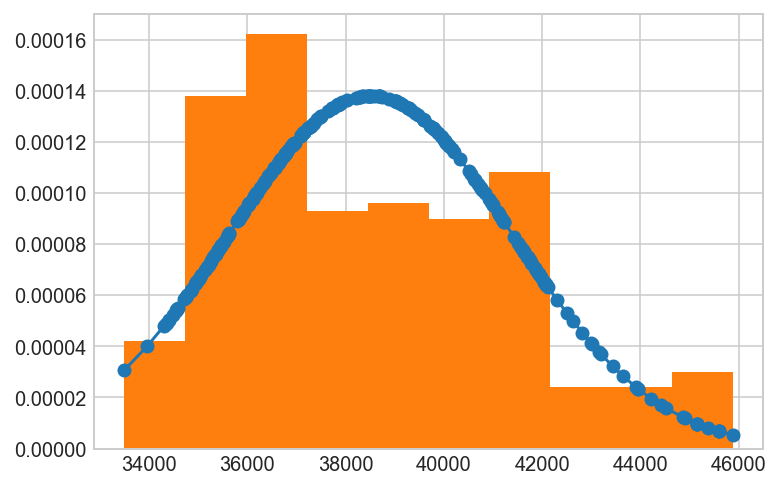

In [24]:
c = sorted(data1['Total Cost'])  #sorted

fit = stats.norm.pdf(c, np.mean(c), np.std(c))  #this is a fitting indeed

pl.plot(c,fit,'-o')

pl.hist(c,normed=True)      #use this to draw histogram of your data

pl.show()

In [25]:
data1['cost score']=[(((max(data1['Total Cost'])- x)/(max(data1['Total Cost'])-min(data1['Total Cost'])))*4)+1 for x in data1['Total Cost'] ]

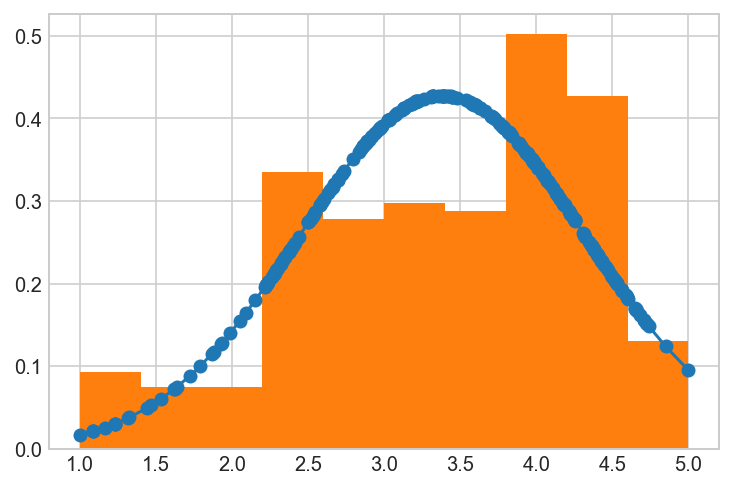

In [26]:
h = sorted(data1['cost score'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show() 

In [27]:
df=pd.DataFrame({'cost score':data1['cost score'], 'boxcox' : scipy.stats.boxcox(data1['cost score'], lmbda=None, alpha=None)[0] ,
                "variationidtemp":data1["variationidtemp"]})

In [28]:
data=pd.merge(data1,df,how='left',on=['variationidtemp','cost score']).drop_duplicates(subset=None, keep='first', inplace=False)


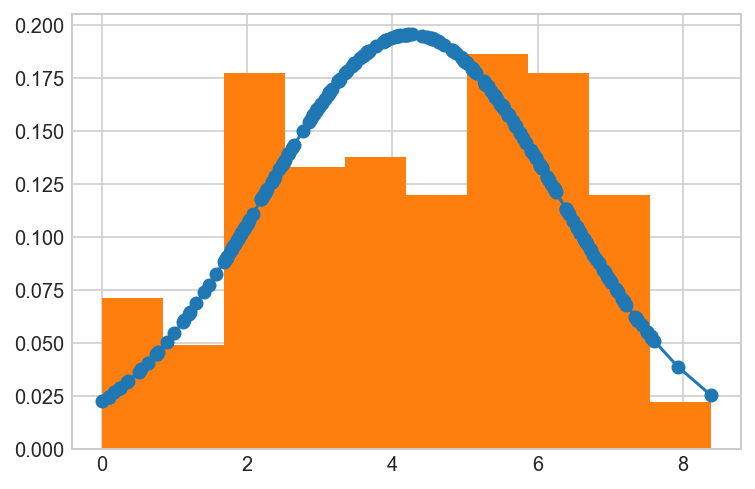

In [29]:
h = sorted(data['boxcox'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()

In [30]:
data['cost score2']=[(((max(data['boxcox'])- x)/(max(data['boxcox'])-min(data['boxcox'])))*5) for x in data['boxcox'] ]



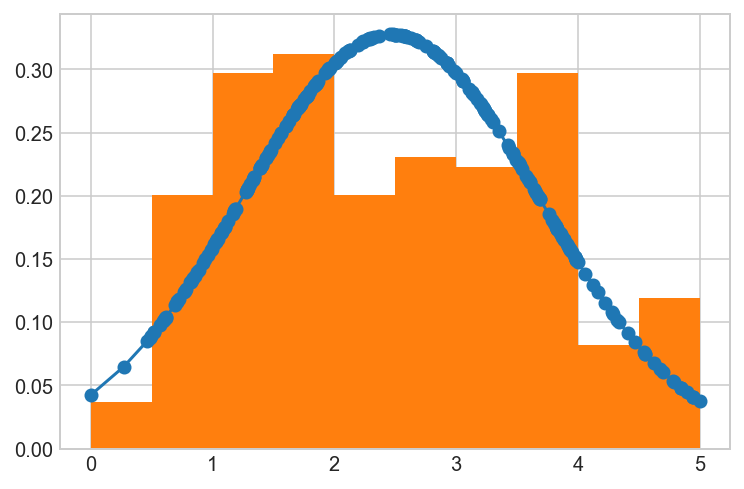

In [31]:
h = sorted(data['cost score2'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()

In [32]:
print(len(data[(data['cost score2'] >= 0) & (data['cost score2'] < 0.25)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 0.25) & (data['cost score2'] < 0.75)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 0.75) & (data['cost score2'] < 1.25)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 1.25) & (data['cost score2'] < 1.75)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 1.75) & (data['cost score2'] < 2.25)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 2.25) & (data['cost score2'] < 2.75)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 2.75) & (data['cost score2'] < 3.25)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 3.25) & (data['cost score2'] < 3.75)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 3.75) & (data['cost score2'] < 4.25)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 4.25) & (data['cost score2'] < 4.75)])/len(data['cost score2']) * 100)

print(len(data[(data['cost score2'] >= 4.75) & (data['cost score2'] <= 5)])/len(data['cost score2']) * 100)

0.37174721189591076
5.947955390334572
11.895910780669144
16.356877323420075
13.754646840148698
9.66542750929368
12.639405204460965
10.037174721189592
11.152416356877323
4.4609665427509295
3.717472118959108


In [33]:
data.shape

(269, 117)

In [34]:
data2=pd.read_csv('personal_rtr_output.csv',sep=',')

In [35]:
data2.columns

Index(['variationidtemp', 'Average Rate', 'Intial_Repayment',
       'balance_outstanding', 'Repayment', 'fees', 'Total_Cost', 'Flex Points',
       'Cost Score', 'Flex Score', 'Total Score'],
      dtype='object')

In [36]:
data2.shape

(269, 11)

In [37]:
data2=data2[['variationidtemp','Total Score']]

In [38]:
my_data= pd.merge(data,data2,on='variationidtemp',how='inner')

In [39]:
my_data.shape

(277, 118)

# Flex Score Inputs + Cost Score + Y

In [40]:
my_df= my_data[['variationidtemp','Isextrarepaymentsallowed','Repaymentfreq','Hasredrawfacility',
             'extrarepaymentdollarlimits','Redrawactivationfee','Hasearlyexitpenalty','Securedtype','cost score2',
             'Total Score']]

In [41]:
def monthly(row):
    if "Monthly" in row['Repaymentfreq']:
        return "monthly"
def fortnightly(row):
    if "Fortnightly" in row['Repaymentfreq']:
        return "fortnightly"
def weekly(row):
    if "Weekly" in row['Repaymentfreq']:
        return "weekly"
    
my_df['Monthly']= my_df.apply(monthly,axis=1)
my_df['Fortnightly']= my_df.apply(fortnightly,axis=1)
my_df['Weekly']= my_df.apply(weekly,axis=1)

/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [42]:
del my_df['Repaymentfreq']

In [43]:
my_df['Isextrarepaymentsallowed'].unique()

array(['YES', 'NO', 'UNKNOWN', nan], dtype=object)

In [44]:
my_df['Isextrarepaymentsallowed']=my_df['Isextrarepaymentsallowed'].replace(['UNKNOWN',np.NaN,np.nan,'nan'],'NO')

/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
my_df['Isextrarepaymentsallowed'].unique()

array(['YES', 'NO'], dtype=object)

In [46]:
my_df['Hasredrawfacility'].unique()

array(['NO', 'YES', 'UNKNOWN'], dtype=object)

In [47]:
my_df['Hasredrawfacility']=my_df['Hasredrawfacility'].replace(['UNKNOWN',np.NaN,np.nan,'nan'],'NO')

/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
my_df['Hasearlyexitpenalty'].unique()

array(['YES', 'NO', nan], dtype=object)

In [49]:
my_df['Hasearlyexitpenalty']=my_df['Hasearlyexitpenalty'].replace(['UNKNOWN',np.NaN,np.nan,'nan'],'NO')

/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
YES_NO_map={'YES': 1, 'NO': 0}
my_df['Isextrarepaymentsallowed']=my_df['Isextrarepaymentsallowed'].map(YES_NO_map)
my_df['Hasredrawfacility']=my_df['Hasredrawfacility'].map(YES_NO_map)
my_df['Hasearlyexitpenalty']=my_df['Hasearlyexitpenalty'].map(YES_NO_map)
my_df['Securedtype']=my_df['Securedtype'].map({'SECURED': 1, 'UNSECURED': 0})
my_df['Monthly']=my_df['Monthly'].map({'monthly': 1, None: 0})
my_df['Fortnightly']=my_df['Fortnightly'].map({'fortnightly': 1, None: 0})
my_df['Weekly']=my_df['Weekly'].map({'weekly': 1, None: 0})


/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [51]:
my_df['extrarepaymentdollarlimits']=my_df['extrarepaymentdollarlimits'].replace([np.NaN,np.nan],0)

/Users/indraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
my_df.columns


Index(['variationidtemp', 'Isextrarepaymentsallowed', 'Hasredrawfacility',
       'extrarepaymentdollarlimits', 'Redrawactivationfee',
       'Hasearlyexitpenalty', 'Securedtype', 'cost score2', 'Total Score',
       'Monthly', 'Fortnightly', 'Weekly'],
      dtype='object')

In [83]:
my_df

,variationidtemp,Isextrarepaymentsallowed,Hasredrawfacility,extrarepaymentdollarlimits,Redrawactivationfee,Hasearlyexitpenalty,Securedtype,cost score2,Total Score,Monthly,Fortnightly,Weekly
0,360 Finance - bad4bd19-2845-48fb-b775-65ad044f...,1,0,0.0,0,1,1,5.000000,1.000700,1,1,1
1,ANZ - c8aae046-e882-44d9-9a62-47e406a03fb8 - 1...,1,0,0.0,0,1,0,3.170794,2.697047,1,1,1
2,Auswide Bank - edcbaebe-5b04-4c62-a05a-2a3229f...,1,0,0.0,0,1,1,2.484888,3.065427,1,0,0
3,Auswide Bank - fe44f1e9-1d34-493e-8f9b-cd44c4a...,1,0,0.0,0,1,1,1.435587,3.678343,1,0,0
4,Auswide Bank - b6569a50-113e-4b0a-a15e-448e5fc...,1,0,0.0,0,1,1,3.058299,2.691399,1,0,0
5,Auswide Bank - 04017ee5-b8e6-4c6f-b02c-7a5ad8b...,1,0,0.0,0,1,1,2.677901,2.943257,1,0,0
6,Bank of us - 0b4a8349-4575-4c62-8add-c94ac94b4...,1,0,0.0,0,0,1,2.022900,3.428272,1,1,1
7,Bank of us - 7fc1cb18-b884-481a-810d-ba8ccb3ca...,1,0,0.0,0,0,1,0.821672,4.089005,1,1,1
8,Bank Australia - a818e94c-9542-4d59-81c5-1fed3...,1,0,0.0,0,0,0,3.256190,2.636980,1,1,1
9,BankSA - e7efba54-02f7-4982-840f-b158f4c4daec ...,1,1,0.0,0,0,0,4.944375,1.495818,1,0,0


In [54]:
y= my_df['Total Score']
X= my_df.drop(['variationidtemp','Total Score'],axis=1)


# Standardisation

In [55]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(X)

# Train-Test Split

In [57]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.50)

# Feature Selection

In [58]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
scorer = make_scorer(mean_squared_error, greater_is_better = False)
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

# Ridge

In [59]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

Best alpha : 0.01
Try again for more precision with alphas centered around 0.01
Best alpha : 0.014
Ridge RMSE on Training set : 0.100716848426
Ridge RMSE on Test set : 0.149595289119


In [60]:
ridge_coefs = pd.DataFrame({'abs_coeff':abs(ridge.coef_),'ridge_coeff':ridge.coef_,'input' : X.columns})

In [61]:
test = ridge_coefs.sort_values(['abs_coeff'], ascending=[False]);test

,abs_coeff,input,ridge_coeff
6,0.824776,cost score2,-0.824776
0,0.284277,Isextrarepaymentsallowed,0.284277
1,0.238083,Hasredrawfacility,0.238083
7,0.023369,Monthly,0.023369
8,0.010655,Fortnightly,0.010655
9,0.009714,Weekly,0.009714
5,0.008273,Securedtype,0.008273
2,0.005592,extrarepaymentdollarlimits,0.005592
4,0.003901,Hasearlyexitpenalty,-0.003901
3,0.000000,Redrawactivationfee,0.000000


In [62]:
test.input

6                   cost score2
0      Isextrarepaymentsallowed
1             Hasredrawfacility
7                       Monthly
8                   Fortnightly
9                        Weekly
5                   Securedtype
2    extrarepaymentdollarlimits
4           Hasearlyexitpenalty
3           Redrawactivationfee
Name: input, dtype: object

In [63]:
X_new=my_df[['cost score2','Isextrarepaymentsallowed','Hasredrawfacility','Monthly','Fortnightly','Weekly',
              'Securedtype','extrarepaymentdollarlimits','Hasearlyexitpenalty'
]]

In [64]:
Xn_new=ss.fit_transform(X_new)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.50)

# Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
rf = RandomForestRegressor(n_estimators=1500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [68]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.967
Test data R-2 score: 0.977
Test data Spearman correlation: 0.995
Test data Pearson correlation: 0.99


In [69]:
test_df=pd.DataFrame({'total_score':y_test,'predictions':rf.fit(X_train, y_train).predict(X_test)})

In [70]:
test_df['y_round']= round(y_test,1)
test_df['pred_round']= round(test_df['predictions'],1)
test_df['Difference']= test_df['pred_round']-test_df['y_round']

In [71]:
Accuracy= len(test_df[test_df['Difference']==0])/len(test_df['Difference']); Accuracy*100

59.71223021582733

In [72]:
len(test_df[test_df['Difference']==0])

83

In [77]:
len(test_df[test_df['Difference'] < -0.1])

22

In [73]:
len(test_df['Difference'])

139

In [74]:
max(test_df['Difference'])

1.0

In [75]:
min(test_df['Difference'])

-0.19999999999999973

Text(0,0.5,'Predictions')

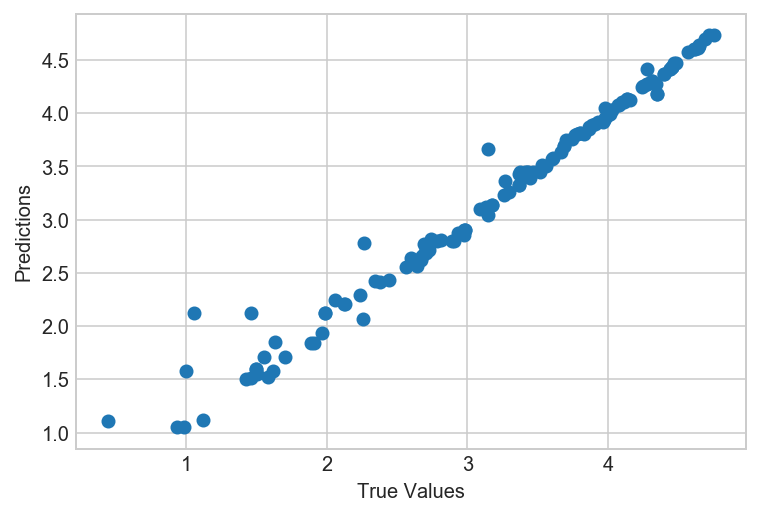

In [82]:
plt.scatter(y_test, test_df['predictions'])
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [76]:
test_df

,predictions,total_score,y_round,pred_round,Difference
80,2.551362,2.562535,2.6,2.6,0.0
174,2.567107,2.639824,2.6,2.6,0.0
8,2.623072,2.636980,2.6,2.6,0.0
226,4.300427,4.316643,4.3,4.3,0.0
83,3.326338,3.366542,3.4,3.3,-0.1
4,2.773884,2.691399,2.7,2.8,0.1
227,4.074313,4.075739,4.1,4.1,0.0
33,4.629009,4.647092,4.6,4.6,0.0
236,4.030803,4.028414,4.0,4.0,0.0
190,3.794178,3.767985,3.8,3.8,0.0


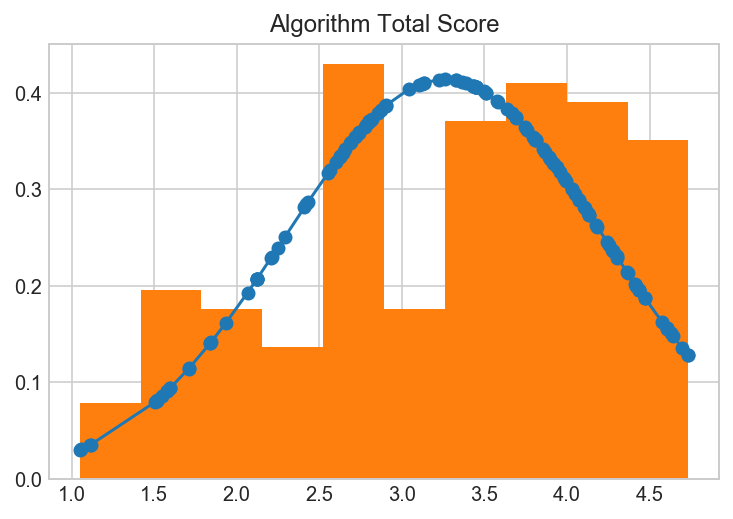

In [81]:
h = sorted(test_df['predictions'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.title("Algorithm Total Score")

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()

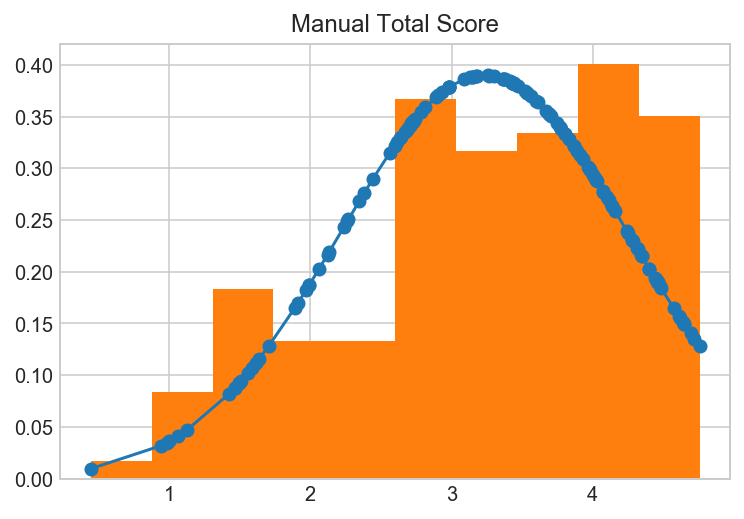

In [80]:
h = sorted(test_df['total_score'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.title("Manual Total Score")

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()